## StarTracker Tracking drift check - 28-Mar-23

HyeYun Park and Adrian Shestakov - checking calibrated ra and dec during tracking

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
days_per_min = 1/24 * 1/60
arcsec_per_deg = 60**2

class RaDecTimeSeries():
    _sequence_range = (2, 111)
    _dayObs = 20230309
    _good_sequence_range = True
    
    @property
    def sequence_range(self):
        return self._sequence_range
    
    @property
    def dayObs(self):
        return self._dayObs
    
    @property
    def good_sequence_range(self):
        return self._good_sequence_range

    def set_sequence_range(self, sequenceTuple):
        self._sequence_range = sequenceTuple
    
    def set_dayObs(self, dayObs):
        self._dayObs = dayObs
        
    def __init__(self):
        return
    
    def read_table(self):
        mdFilename = os.path.join('/project/rubintv/starTracker/sidecar_metadata', f'dayObs_{self.dayObs}.json')
        data = pd.read_json(mdFilename).T
        data = data.sort_index()
        data = data[['Calculated Ra', 'Calculated Dec', 'MJD']].astype(float)
        data.dropna(inplace=True)
        
        self.ra = data['Calculated Ra']
        self.dec = data['Calculated Dec']
        self.time = data['MJD']

    def analyze(self):
        (start_seq, end_seq) = self.sequence_range

        # Selecting range of seq number of one tracking
        calculated_ra = self.ra.loc[start_seq: end_seq].values
        calculated_dec = self.dec.loc[start_seq: end_seq].values
        time_array = self.time.loc[start_seq: end_seq].values
                
        try:
            # Making linear fit for ra vs time, dec vs time
            coef_ra, cov_ra = np.polyfit(time_array, calculated_ra, 1, cov=True)
            coef_dec, cov_dec = np.polyfit(time_array, calculated_dec, 1, cov=True)
        except Exception as e:
            print(f"Couldn't analyze sequence range ({start_seq}, {end_seq}). "\
            f"Error message: {e}. Skipping.")
            self._good_sequence_range = False
        # This gets executed iff no exception
        else:
            # Some sequences fit but return negative covariance diagonals
            if cov_ra[0, 0] <= 0 or cov_dec[0, 0] <= 0:
                self._good_sequence_range = False
            else:
                # Time formatting
                time_mjd = Time(time_array, format='mjd', scale='utc')
                time_mjd.format = 'fits'

                # Store values
                self.date = time_mjd.strftime('%Y %b %d')[0]
                self.ra_fit_coefs = coef_ra
                self.ra_fit_cov = cov_ra
                self.dec_fit_coefs = coef_dec
                self.dec_fit_cov = cov_dec
                self.mean_dec = calculated_dec.mean()
                self._good_sequence_range = True
            
            
    def plot(self, figures_dir=None):
        (start_seq, end_seq) = self.sequence_range

        # Selecting range of seq number of one tracking
        calculated_ra = self.ra.loc[start_seq: end_seq].values
        calculated_dec = self.dec.loc[start_seq: end_seq].values
        time_array = self.time.loc[start_seq: end_seq].values
        
        # Get slopes and uncertainties
        slope_ra = self.ra_fit_coefs[0] * days_per_min * arcsec_per_deg
        slope_uncertainty_ra = np.sqrt(self.ra_fit_cov[0, 0]) * days_per_min * arcsec_per_deg
        slope_dec = self.dec_fit_coefs[0] * days_per_min * arcsec_per_deg
        slope_uncertainty_dec = np.sqrt(self.dec_fit_cov[0, 0]) * days_per_min * arcsec_per_deg
        
        # Make prediction data
        poly1d_fn_ra = np.poly1d(self.ra_fit_coefs)
        poly1d_fn_dec = np.poly1d(self.dec_fit_coefs)
        predicted_ra = poly1d_fn_ra(time_array)
        predicted_dec = poly1d_fn_dec(time_array)
        
        # Plotting
        plt.set_loglevel('WARNING')
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        fig.subplots_adjust(hspace=0)

        # RA
        ax1_r = self._add_residual_ax(ax1)
        self._plot_data_and_residuals(ax1, ax1_r, time_array, calculated_ra, predicted_ra)

        # RA Labelling
        ax1.set_title(f'Calculated Ra & Dec {self.date}, seq num {start_seq}~{end_seq} ', fontsize=16)
        ax1.set_ylabel('Calculated Ra', fontsize=14)
        ax1.text(x=time_array[len(time_array)//8], y=np.max(calculated_ra),
                 s=fr"slope={slope_ra:.4e} $\pm$ {slope_uncertainty_ra:.2e}(arcsec / min)",
                 bbox=dict(facecolor='white', alpha=0.5))
        ax1.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

        # RA Residuals Labelling
        ax1_r.set_ylabel('Ra\nResidual', fontsize=14)
        ax1_r.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
        ax1_r.set_xticks([])

        # Dec
        ax2_r = self._add_residual_ax(ax2)
        self._plot_data_and_residuals(ax2, ax2_r, time_array, calculated_dec, predicted_dec)

        # Dec Labelling
        ax2.set_ylabel('Calculated Dec', fontsize=14)
        ax2.text(x=time_array[len(time_array)//8], y=np.max(calculated_dec),
                 s=fr"slope={slope_dec:.4e} $\pm$ {slope_uncertainty_dec:.2e}(arcsec / min)",
                 bbox=dict(facecolor='white', alpha=0.5))
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

        # Dec Residuals Labelling
        xticks = ax2_r.get_xticks()
        (xlim_l, xlim_r) = ax2_r.get_xlim()
        xticklabels_time = Time(xticks, format="mjd", scale="utc")
        clock_time = xticklabels_time.strftime('%H:%M:%S')
        ax2_r.set_xticks(xticks, labels=clock_time)
        ax2_r.set_xlim(left=xlim_l, right=xlim_r)
        ax2_r.set_xlabel('Time (utc)', fontsize=14)
        ax2_r.set_ylabel('Dec\nResidual', fontsize=14)
        ax2_r.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
        
        if figures_dir:
            fname = f"{self.dayObs}_{self.sequence_range[0]}-{self.sequence_range[1]}_ra_dec_scatter.png"
            fig.savefig(os.path.join(figures_dir, fname))

        plt.show()
        
    def _add_residual_ax(self, ax, size="30%", pad=0):
        divider = make_axes_locatable(ax)
        ax_r = divider.append_axes("bottom", size=size, pad=pad)
        ax.figure.add_axes(ax_r)
        ax.set_xticks([])

        return ax_r

    def _plot_data_and_residuals(self, ax, ax_r, x, y, predicted_y):
        ax.scatter(x, y,  s=25)
        ax.plot(x, predicted_y, '--k')

        residuals = y - predicted_y
        ax_r.axhline(ls="--", c='k')
        ax_r.scatter(x, residuals, marker='x', c='r', alpha=0.75)
        

class TrackingDrift():
    def __init__(self, tracks):
        self.tracks = tracks
        self.ra_slopes = {}
        self.dec_slopes = {}
        self.mean_dec = {}
        self.drift_angular_velocity = {}
        
        for k, v in tracks.items():
            n = len(v)
            self.ra_slopes[k] = np.zeros(n) * np.nan
            self.dec_slopes[k] = np.zeros(n) * np.nan
            self.mean_dec[k] = np.zeros(n) * np.nan
            self.drift_angular_velocity[k] = np.zeros(n) * np.nan
            
    def analyze(self, plot_time_series=True,
                figures_dir='/home/adriansh95/figures/sitcom/starTracker/analysis/trackingDrift'):
        # Initialize an RaRaDecTimeSeries object
        raDecTS = RaDecTimeSeries()
        
        for dayObs, sequences_list in self.tracks.items():
            # Set dayObs and read in table
            raDecTS.set_dayObs(dayObs)
            raDecTS.read_table()

            # Analyze and plot (optional) tracking sequence
            for i, sequence_range in enumerate(sequences_list):
                raDecTS.set_sequence_range(sequence_range)
                raDecTS.analyze()
                
                # Add values if sequence range is good, otherwise add np.nan
                if raDecTS.good_sequence_range:
                    ra_slope = raDecTS.ra_fit_coefs[0]
                    dec_slope = raDecTS.dec_fit_coefs[0]
                    mean_dec = raDecTS.mean_dec
                    self.ra_slopes[dayObs][i] = ra_slope * days_per_min * arcsec_per_deg
                    self.dec_slopes[dayObs][i] = dec_slope * days_per_min * arcsec_per_deg
                    self.mean_dec[dayObs][i] = mean_dec
                    self.drift_angular_velocity[dayObs][i] = np.sqrt((np.cos(mean_dec * np.pi / 180) * ra_slope)**2 +
                                                                      dec_slope**2) * days_per_min * arcsec_per_deg

                    if plot_time_series:
                        raDecTS.plot(figures_dir=figures_dir)
                    
    def plot(self, figures_dir=None):
        # Get ra and dec slopes for all days
        all_ra_slopes = np.concatenate([v for v in self.ra_slopes.values()])
        all_dec_slopes = np.concatenate([v for v in self.dec_slopes.values()])
        all_drift_angular_velocities = np.concatenate([v for v in self.drift_angular_velocity.values()])
        rms_drift_requirement = 1 / 10 # Arcsec / min
        
        # Drop nans
        all_ra_slopes = all_ra_slopes[~np.isnan(all_ra_slopes)]
        all_dec_slopes = all_dec_slopes[~np.isnan(all_dec_slopes)]
        all_drift_angular_velocities = all_drift_angular_velocities[~np.isnan(all_drift_angular_velocities)]
        
        # Calculate rms_drift after dropping nans
        rms_drift = np.sqrt(np.mean(np.square(all_drift_angular_velocities)))
        
        # Plot
        days = [str(k) for k in self.tracks.keys()]
        days_string = ", ".join(days)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        ax1.hist([all_ra_slopes, all_dec_slopes], histtype="step", color=['r', 'k'],
                label=["Ra", "Dec"], stacked=False, lw=3.5)
        ax1.set_xlabel("Coordinate Drift Velocity (Arcsec / Min)", fontsize=16)
        ax1.set_title(f"{days_string} Tracking Drift", fontsize=20)
        ax1.legend()
        
        ax2.hist(all_drift_angular_velocities, histtype="step", lw=3.5)
        ax2.set_xlabel("Angular Drift Velocity (Arcsec / Min)", fontsize=16)
        ax2.axvline(x=rms_drift_requirement, ls="--", c='k', label="Requirement")
        ax2.axvline(x=rms_drift, ls=":", c='r', label="RMS")
        ax2.legend()
        
        
        fig.tight_layout()
        
        if figures_dir:
            fname = '_'.join(days) + "_tracking_drift_histogram.png"
            fig.savefig(os.path.join(figures_dir, fname))
            
        plt.show()

picking the seq number based on the (night log) (https://confluence.lsstcorp.org/pages/viewpage.action?spaceKey=LSSTCOM&title=23.03.23+StarTracker+Night+Log)


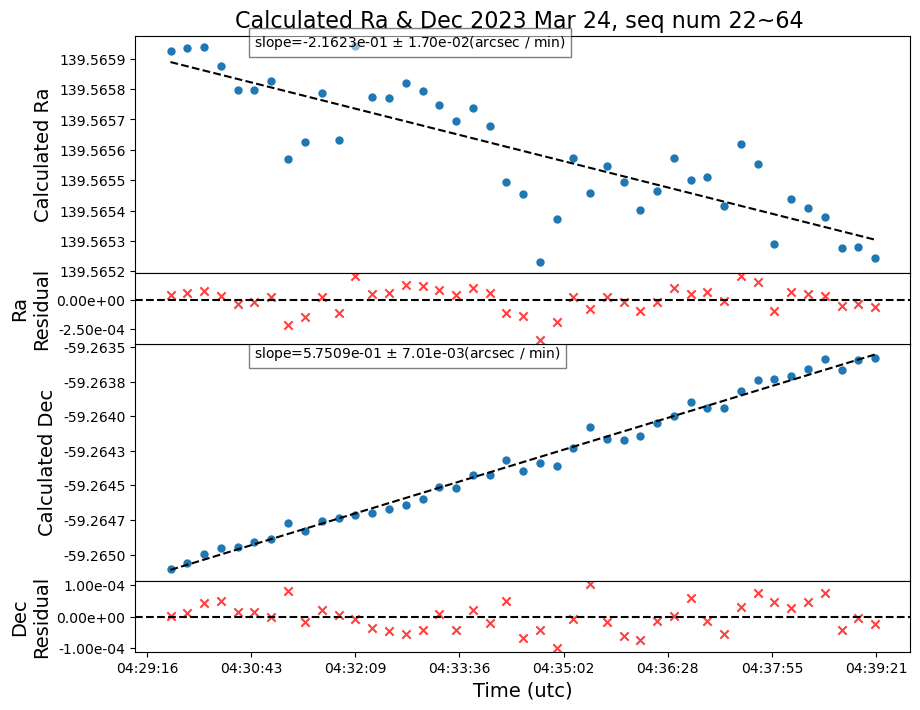

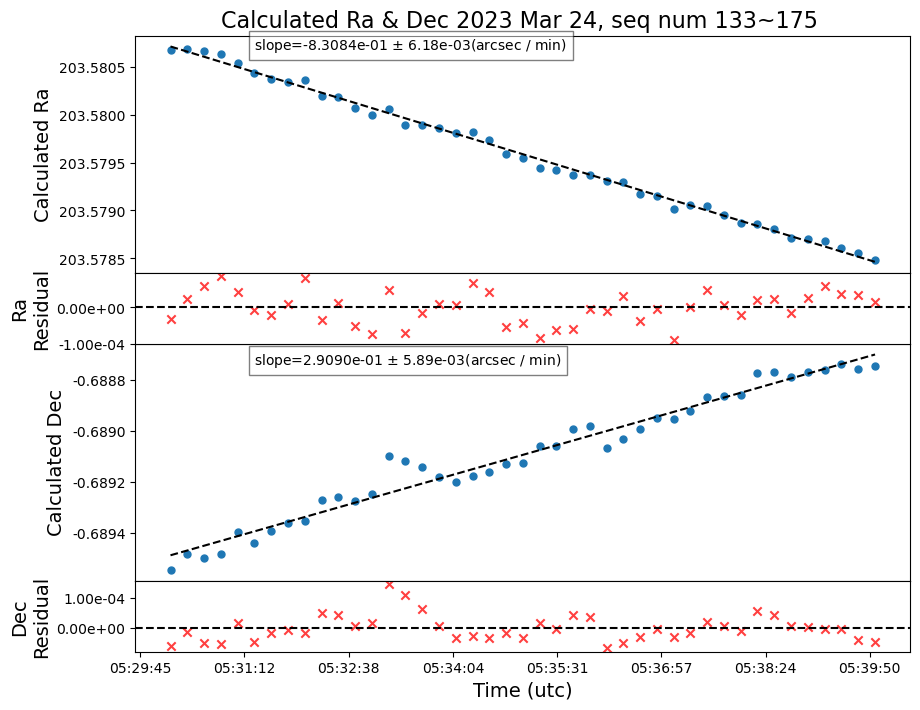

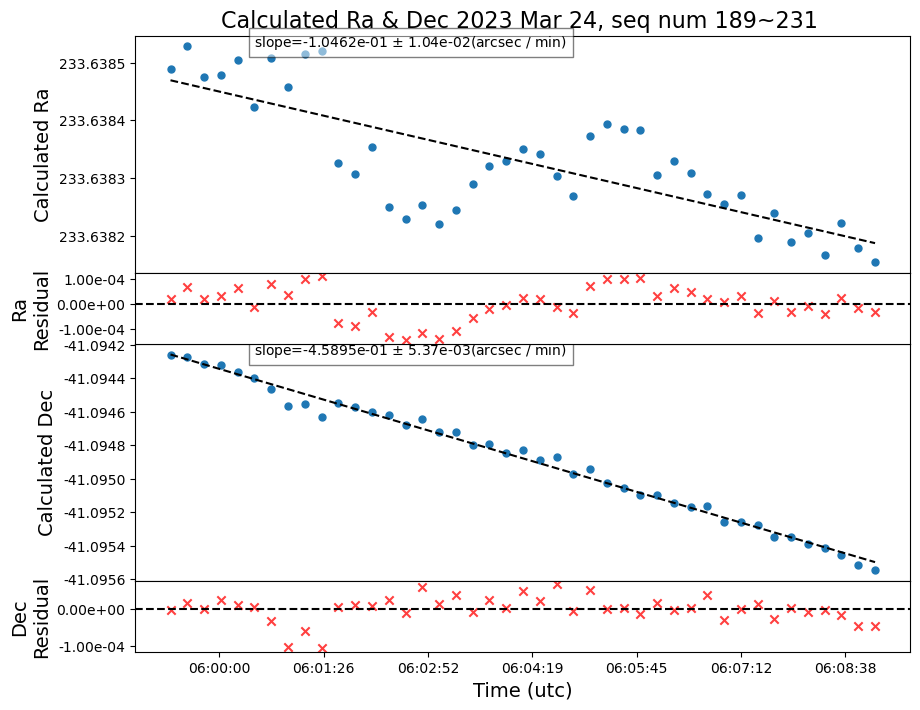

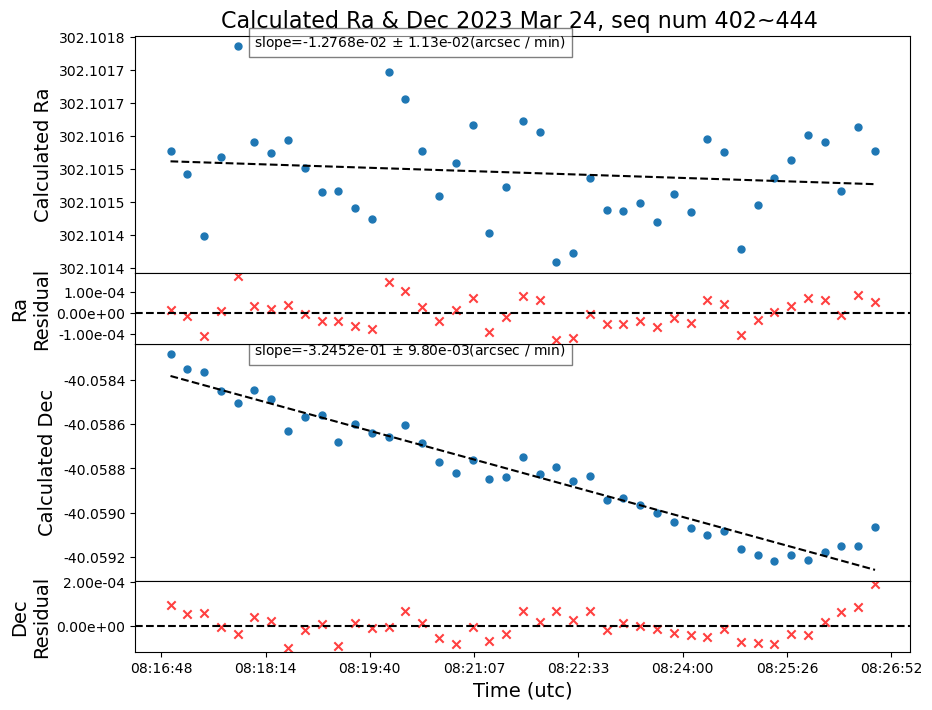

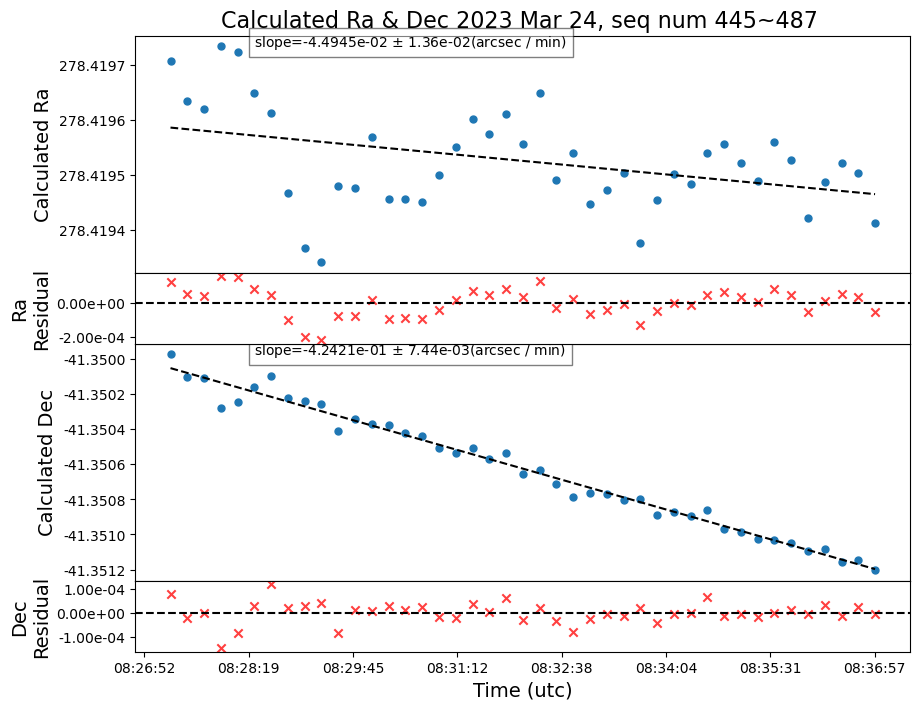

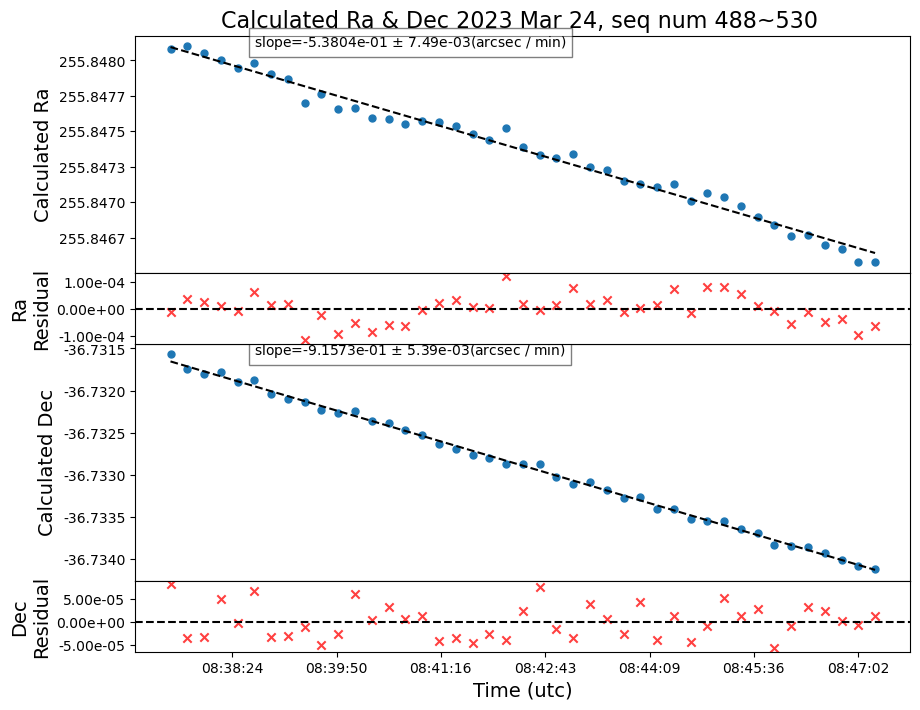

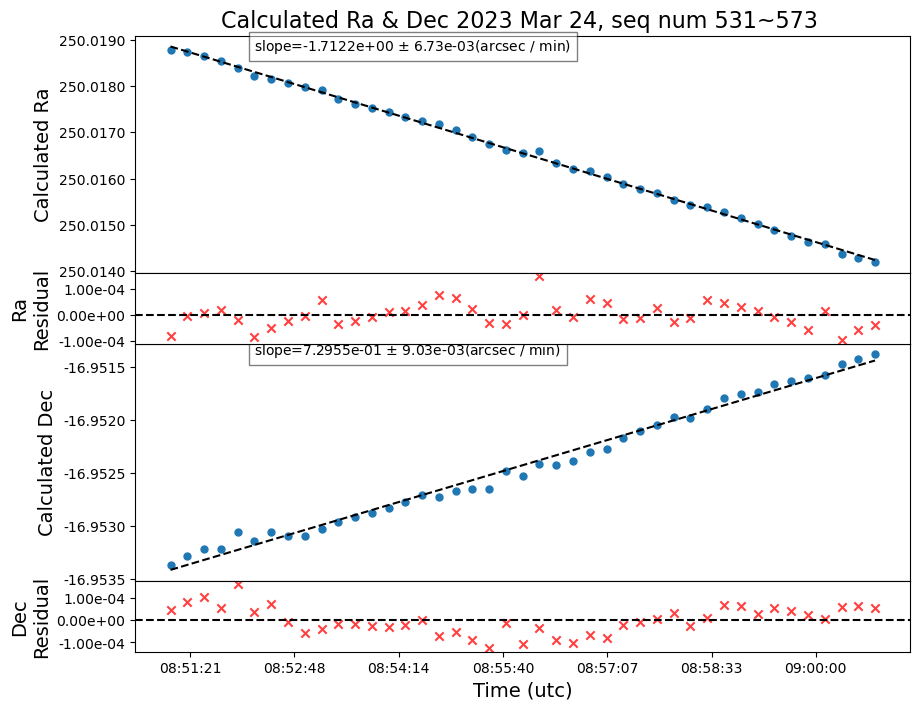

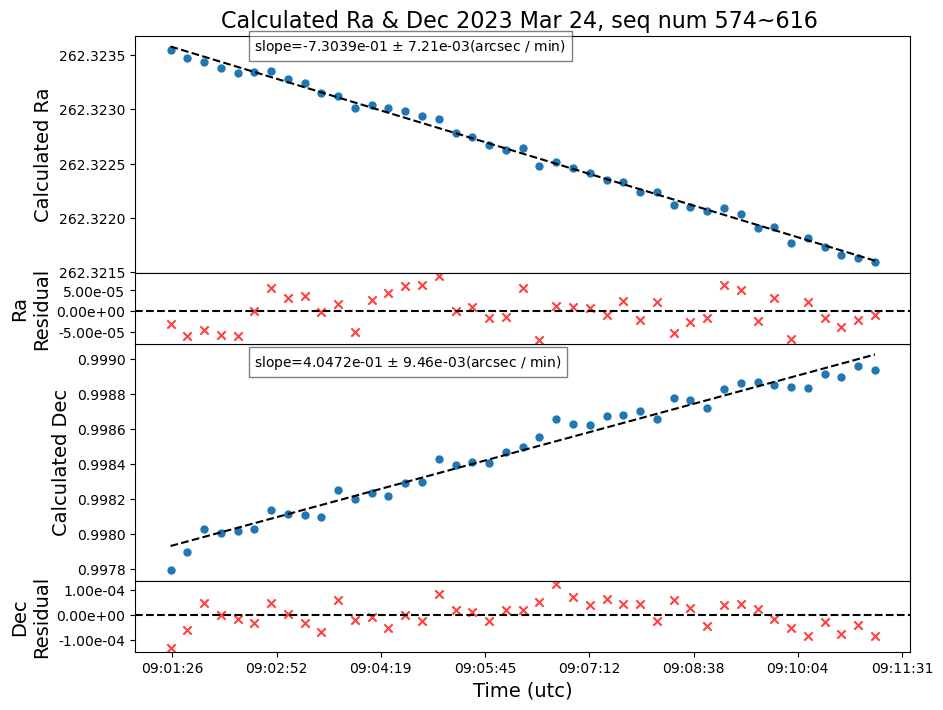

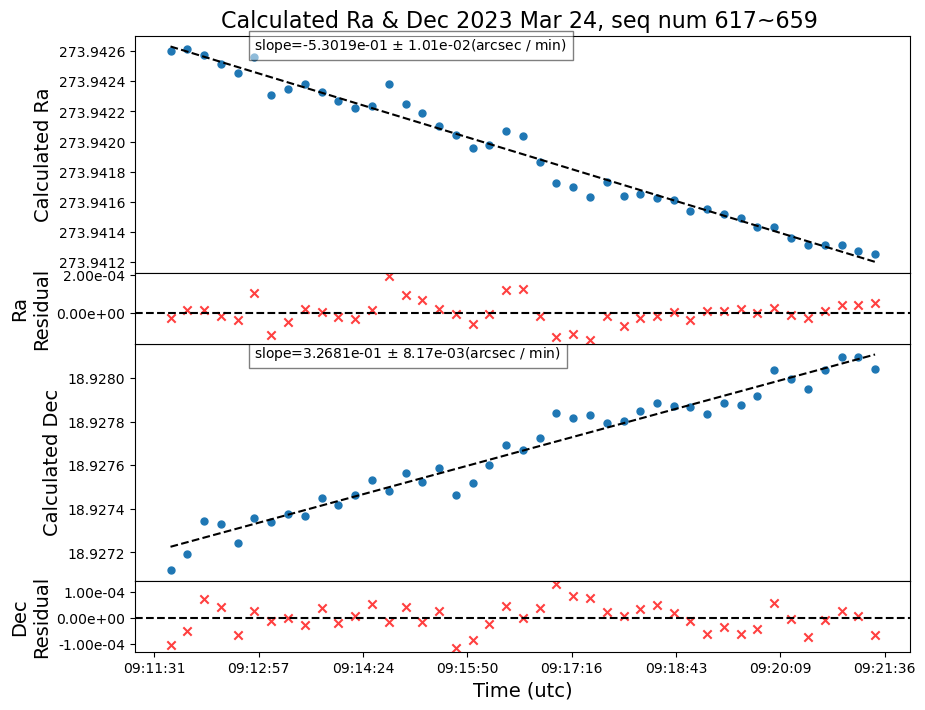

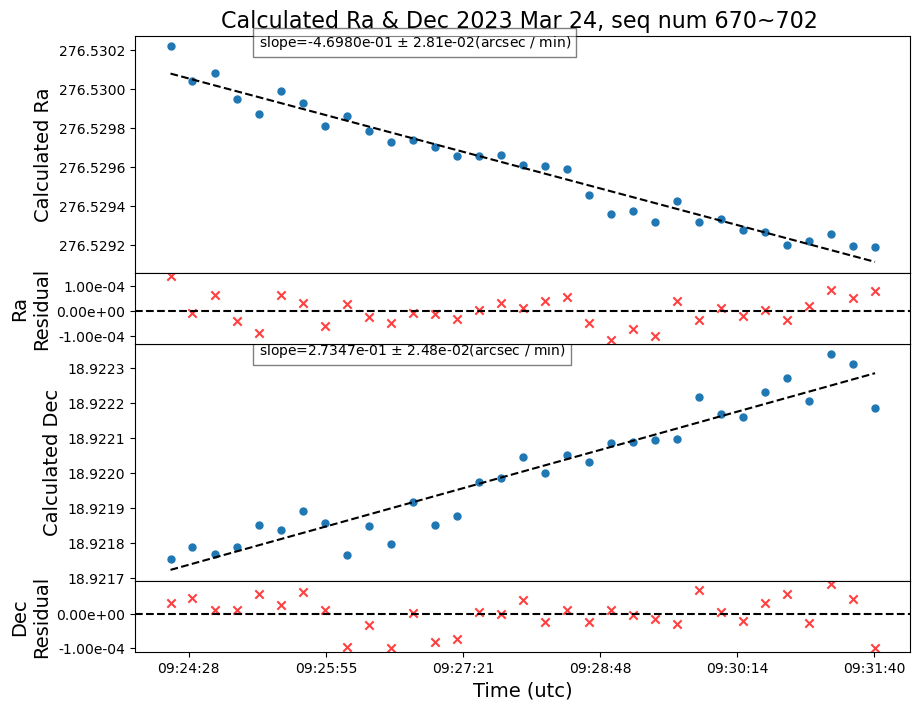

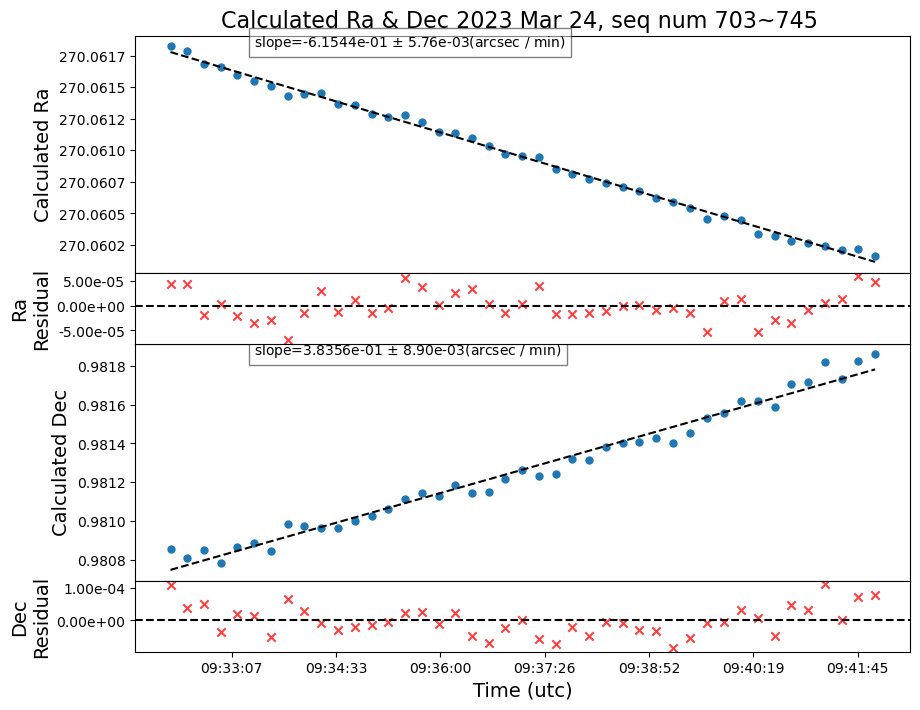

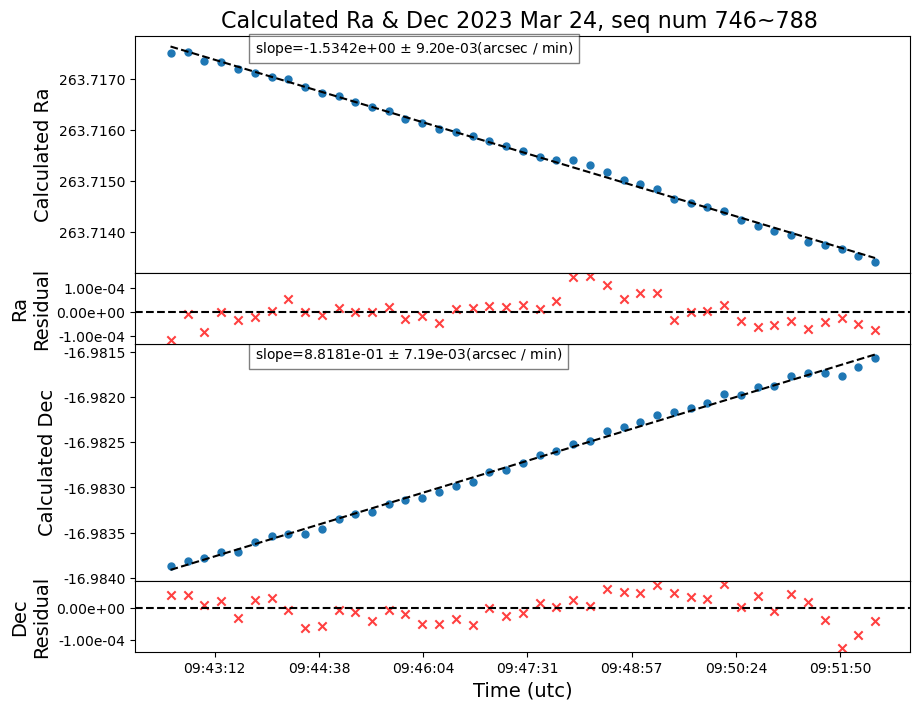

In [3]:
tracks = {20230323: [(22, 64), (68, 100), (133, 175), (179, 188),
                     (189, 231), (402, 444), (445, 487), (488, 530), 
                     (531, 573), (574, 616), (617, 659), (670, 702), 
                     (703, 745), (746, 788)]}
figures_dir = '/home/adriansh95/figures/sitcom/starTracker/analysis/trackingDrift'
trackingDrift = TrackingDrift(tracks)
trackingDrift.analyze(figures_dir=figures_dir)

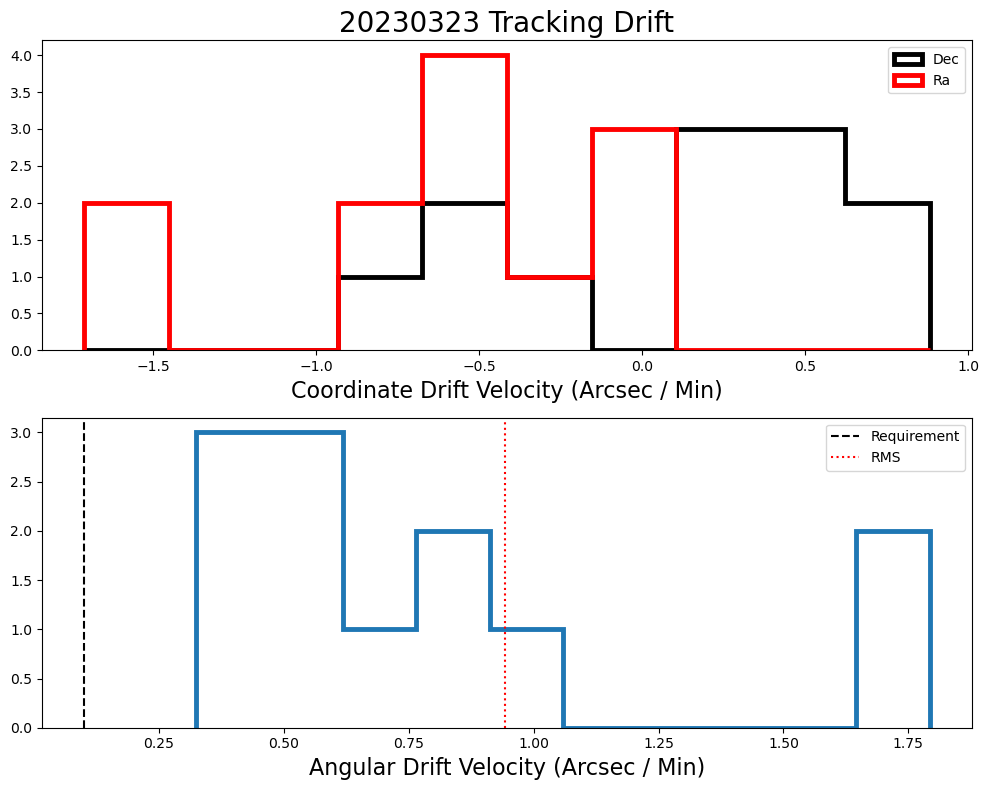

In [4]:
trackingDrift.plot(figures_dir=figures_dir)